In [56]:
from diffusers.utils import load_image, make_image_grid
from PIL import Image
import cv2
import numpy as np
import os
from copy import deepcopy

In [116]:
import matplotlib.pyplot as plt

def display_images_with_titles(images, titles, cols=3):
    """Display a list of PIL images with their titles in a grid format.

    Args:
        images (list): List of PIL Image objects.
        titles (list): List of titles corresponding to each image.
        cols (int): Number of columns in the grid.
    """
    # Calculate the number of rows needed
    n_images = len(images)
    rows = (n_images + cols - 1) // cols  # Ceiling division

    # Create a figure with specified size
    plt.figure(figsize=(12, 4 * rows))

    for i, (image, title) in enumerate(zip(images, titles)):
        ax = plt.subplot(rows, cols, i + 1)  # Create subplot
        ax.imshow(image)  # Display image
        ax.set_title(title)  # Set title
        ax.axis('off')  # Hide axes

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Show the plot


In [106]:
images_dir = "Metadata/Images"
images_path = os.listdir(images_dir)
images_path = [os.path.join(images_dir ,i) for i in images_path]

In [107]:
# Function to extract the numeric part from the filename
def extract_number(file_path):
    # Split the path to get the filename
    filename = file_path.split('/')[-1]  # Get only the filename
    # Extract the number part before the extension
    return int(filename.split('.')[0])  # Convert to integer for proper sorting

# Sort the list using the custom key
sorted_file_paths = sorted(images_path, key=extract_number)

# Print the sorted list
print(sorted_file_paths)

['Metadata/Images/1.png', 'Metadata/Images/2.png', 'Metadata/Images/3.png', 'Metadata/Images/4.png', 'Metadata/Images/5.png', 'Metadata/Images/6.npy', 'Metadata/Images/7.npy']


In [108]:
def get_image(filepath):
    _, file_extension = os.path.splitext(filepath)
    if file_extension == ".png":
        return Image.open(filepath)
    if file_extension == ".npy":
        return Image.fromarray(np.load(filepath))

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

depth_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16, use_safetensors=True)
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16, use_safetensors=True)
normal_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-normal", torch_dtype=torch.float16, use_safetensors=True)


In [175]:
p1 = ["d"]
p2 = ["d" ,"c"]
p3 = ["d" ,"n"]
p4 = ["d" ,"c", "n"]
p5 = ["d" ,"n", "c"]
p6 = ["c" ,"d", "n"]

control_net_map = {"d" : depth_controlnet , "c" : canny_controlnet , "n": normal_controlnet}

In [176]:
def get_controlnet_sequence(seq):
    controlnet = []
    for k in seq:
        controlnet.append(control_net_map[k])
    return controlnet

In [177]:
# List of parameters for each pipeline
parameters = [p1, p2, p3, p4, p5,p6]

# Create a list to hold the pipelines
pipelines = []

# Loop through each parameter to create the pipelines
for param in parameters:
    pipe = StableDiffusionControlNetPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        controlnet=get_controlnet_sequence(param),
        torch_dtype=torch.float16,
        use_safetensors=True
    )
    
    # Set the scheduler and enable CPU offloading
    pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
    pipe.enable_model_cpu_offload()
    
    # Append the pipeline to the list
    pipelines.append(pipe)

# Now you can access each pipeline as pipelines[0], pipelines[1], etc.

Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.04it/s]


In [178]:
text_prompts = ["beautiful landscape, mountains in the background",
"luxury bedroom interior",
"Beautiful snowy mountains",
"luxurious bedroom interior",
"walls with cupboard",
"room with chair",
"House in the forest"]

In [188]:
# Set the seed for reproducibility
seed = 12345
generator = torch.Generator(device="cuda").manual_seed(seed)

In [180]:
def get_canny_image(depth_image):
    canny_image = np.array(deepcopy(depth_image))
    canny_image = cv2.cvtColor(canny_image, cv2.COLOR_BGR2GRAY)
    # Ensure the image is of type uint8
    canny_image = np.uint8(canny_image)
    # Now apply Canny edge detection
    canny_image = cv2.Canny(canny_image, 10,30)
    
    # Convert to three channels (if needed for further processing)
    return Image.fromarray(np.stack((canny_image,) * 3, axis=-1))

def get_normal_image(depth_img):
    # Convert depth image to NumPy array
    depth_array = np.array(depth_img, dtype=np.float32)

    # Check if depth_array has more than 2 dimensions
    if depth_array.ndim > 2:
        # Convert to grayscale by taking the mean across channels
        depth_array = np.mean(depth_array, axis=2)

    # Compute gradients (differences in depth values)
    grad_y, grad_x = np.gradient(depth_array)

    # Normalize gradients
    grad_x /= np.max(np.abs(grad_x)) + 1e-8
    grad_y /= np.max(np.abs(grad_y)) + 1e-8

    # Assuming Z component as constant (1.0), compute normal as cross-product
    normals = np.dstack((-grad_x, -grad_y, np.ones_like(depth_array)))

    # Normalize the normal vectors
    norms = np.linalg.norm(normals, axis=2, keepdims=True)
    normals /= norms

    normal_map = (normals + 1) * 127.5
    normal_map = normal_map.astype(np.uint8)
    normal_image = Image.fromarray(normal_map)

    return normal_image

    

In [181]:
def get_image_map(idx):
    image_map = {}
    image_map["d"] = get_image(sorted_file_paths[idx])
    image_map["c"] = get_canny_image(image_map["d"])
    image_map["n"] = get_normal_image(image_map["d"])
    return image_map
        

In [182]:
def get_image_sequence(idx, seq):
    image_map = get_image_map(idx)
    images = []
    for k in seq:
        images.append(image_map[k])
    return images

In [183]:
def get_title(seq):
    titles = []
    for k in seq :
        if k == "d":
            titles.append("depth")
        if k == "c":
            titles.append("canny")
        if k == "n":
            titles.append("normal")
    return ','.join(titles)

beautiful landscape, mountains in the background


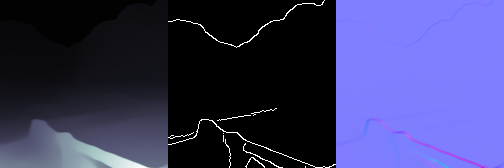

In [189]:
idx = 0
text_prompt = text_prompts[idx]
image_map = get_image_map(idx)
print(text_prompt)
conditioning_images = list(get_image_map(idx).values())
make_image_grid(conditioning_images, rows=1, cols=len(conditioning_images))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.09it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.82it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.75it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.31it/s]


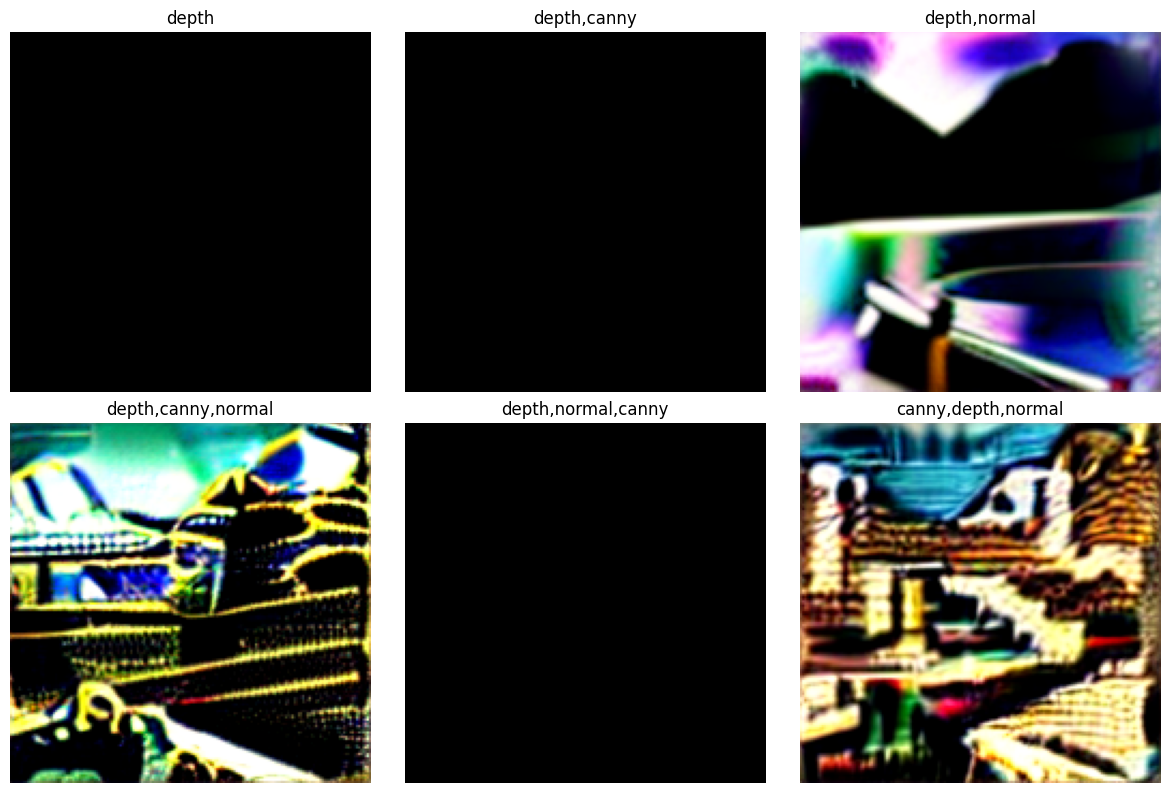

In [190]:
all_outputs = []
titles = []
for i in range(len(parameters)) : 
    images = get_image_sequence(idx, parameters[i])
    output = pipelines[i](
        text_prompt, image=images, generator=generator
    ).images[0]
    all_outputs.append(output)
    titles.append(get_title(parameters[i]))
    
display_images_with_titles(all_outputs, titles)

luxury bedroom interior


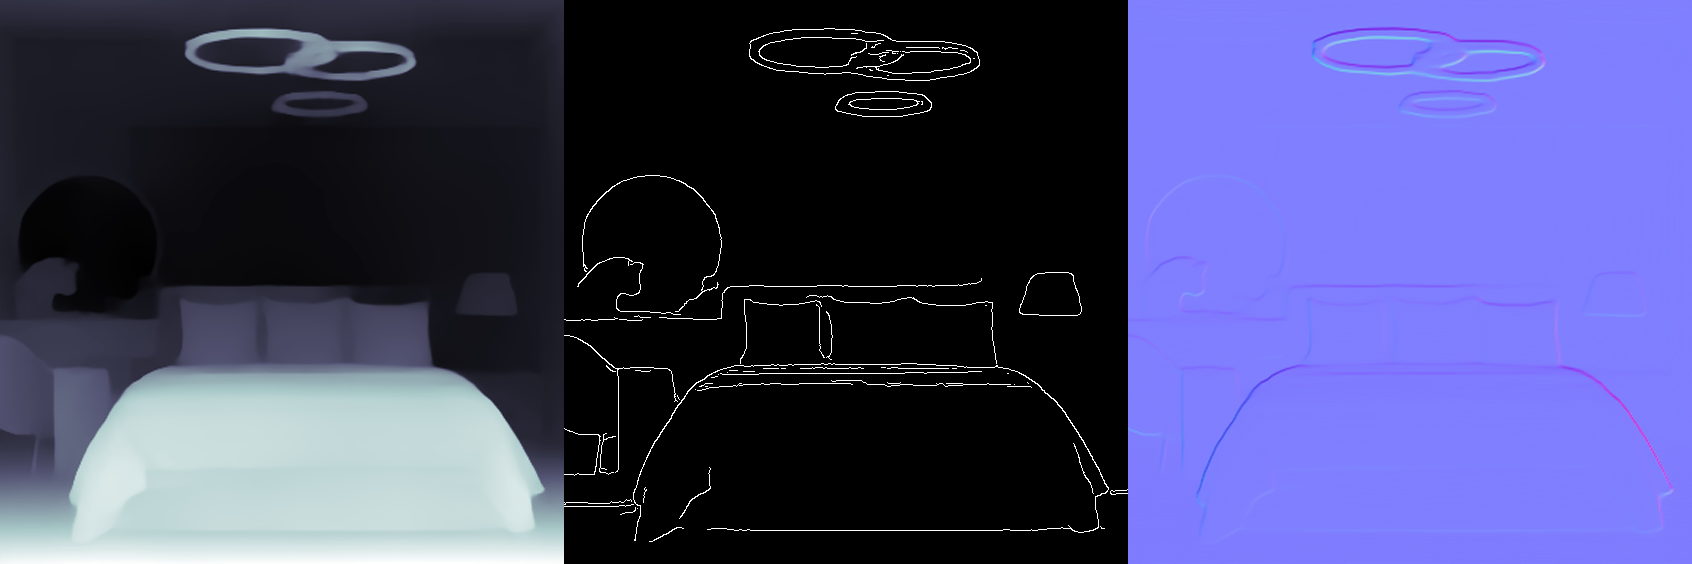

In [191]:
idx = 1
text_prompt = text_prompts[idx]
image_map = get_image_map(idx)
print(text_prompt)
conditioning_images = list(get_image_map(idx).values())
make_image_grid(conditioning_images, rows=1, cols=len(conditioning_images))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.53it/s]


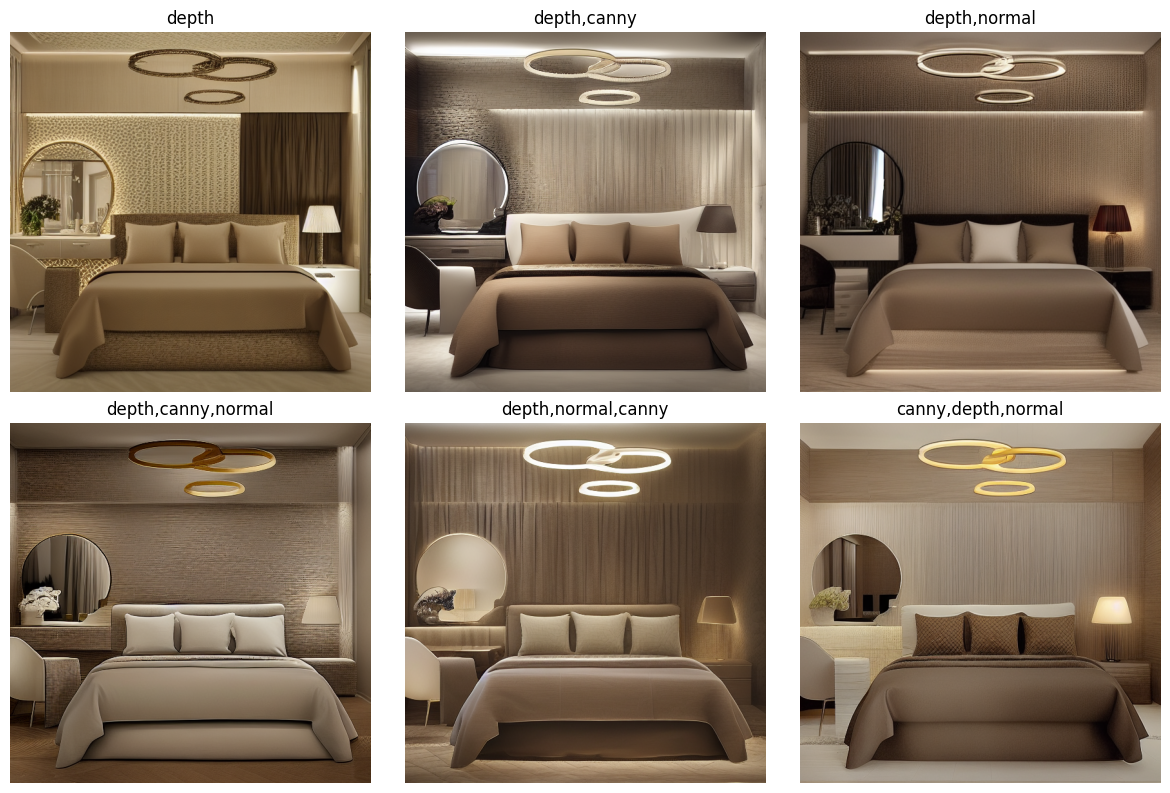

In [192]:
all_outputs = []
titles = []
for i in range(len(parameters)) : 
    images = get_image_sequence(idx, parameters[i])
    output = pipelines[i](
        text_prompt, image=images, generator=generator
    ).images[0]
    all_outputs.append(output)
    titles.append(get_title(parameters[i]))
    
display_images_with_titles(all_outputs, titles)

Beautiful snowy mountains


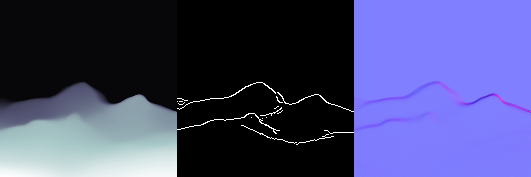

In [193]:
idx = 2
text_prompt = text_prompts[idx]
image_map = get_image_map(idx)
print(text_prompt)
conditioning_images = list(get_image_map(idx).values())
make_image_grid(conditioning_images, rows=1, cols=len(conditioning_images))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.58it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.14it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.63it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


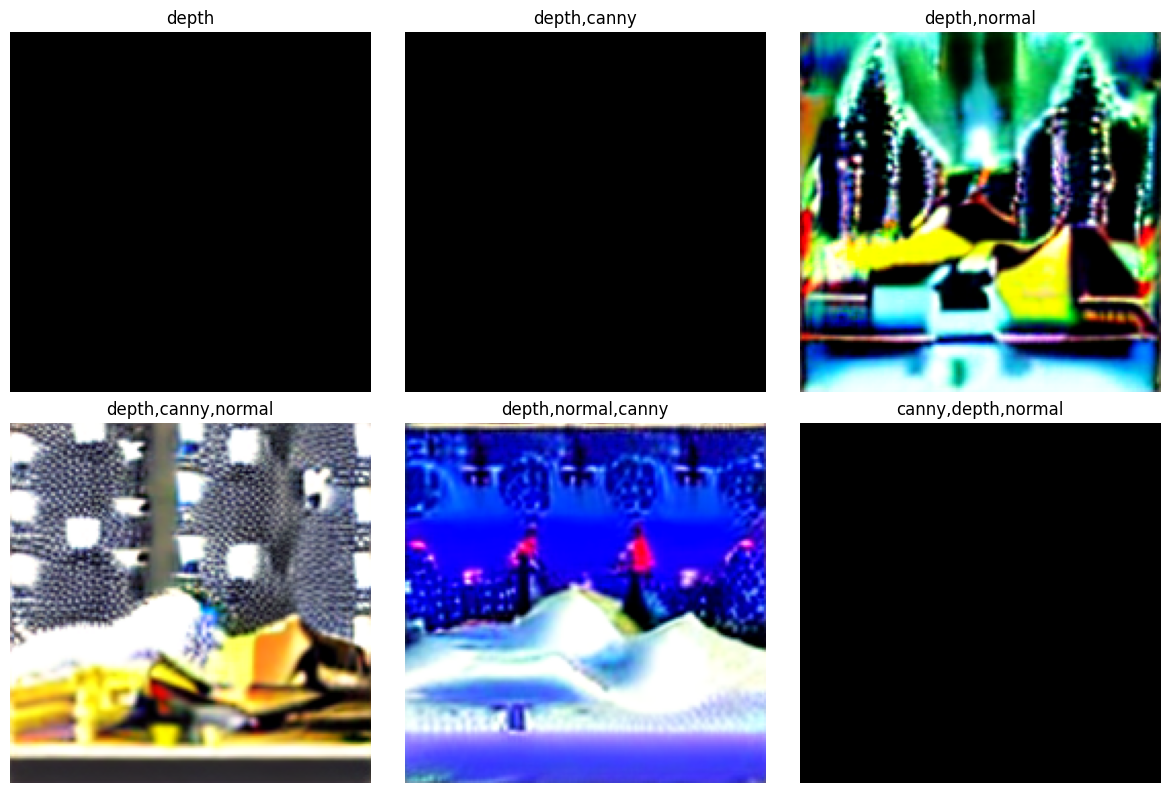

In [197]:
all_outputs = []
titles = []
for i in range(len(parameters)) : 
    images = get_image_sequence(idx, parameters[i])
    output = pipelines[i](
        text_prompt, image=images, generator=generator
    ).images[0]
    all_outputs.append(output)
    titles.append(get_title(parameters[i]))
    
display_images_with_titles(all_outputs, titles)

luxurious bedroom interior


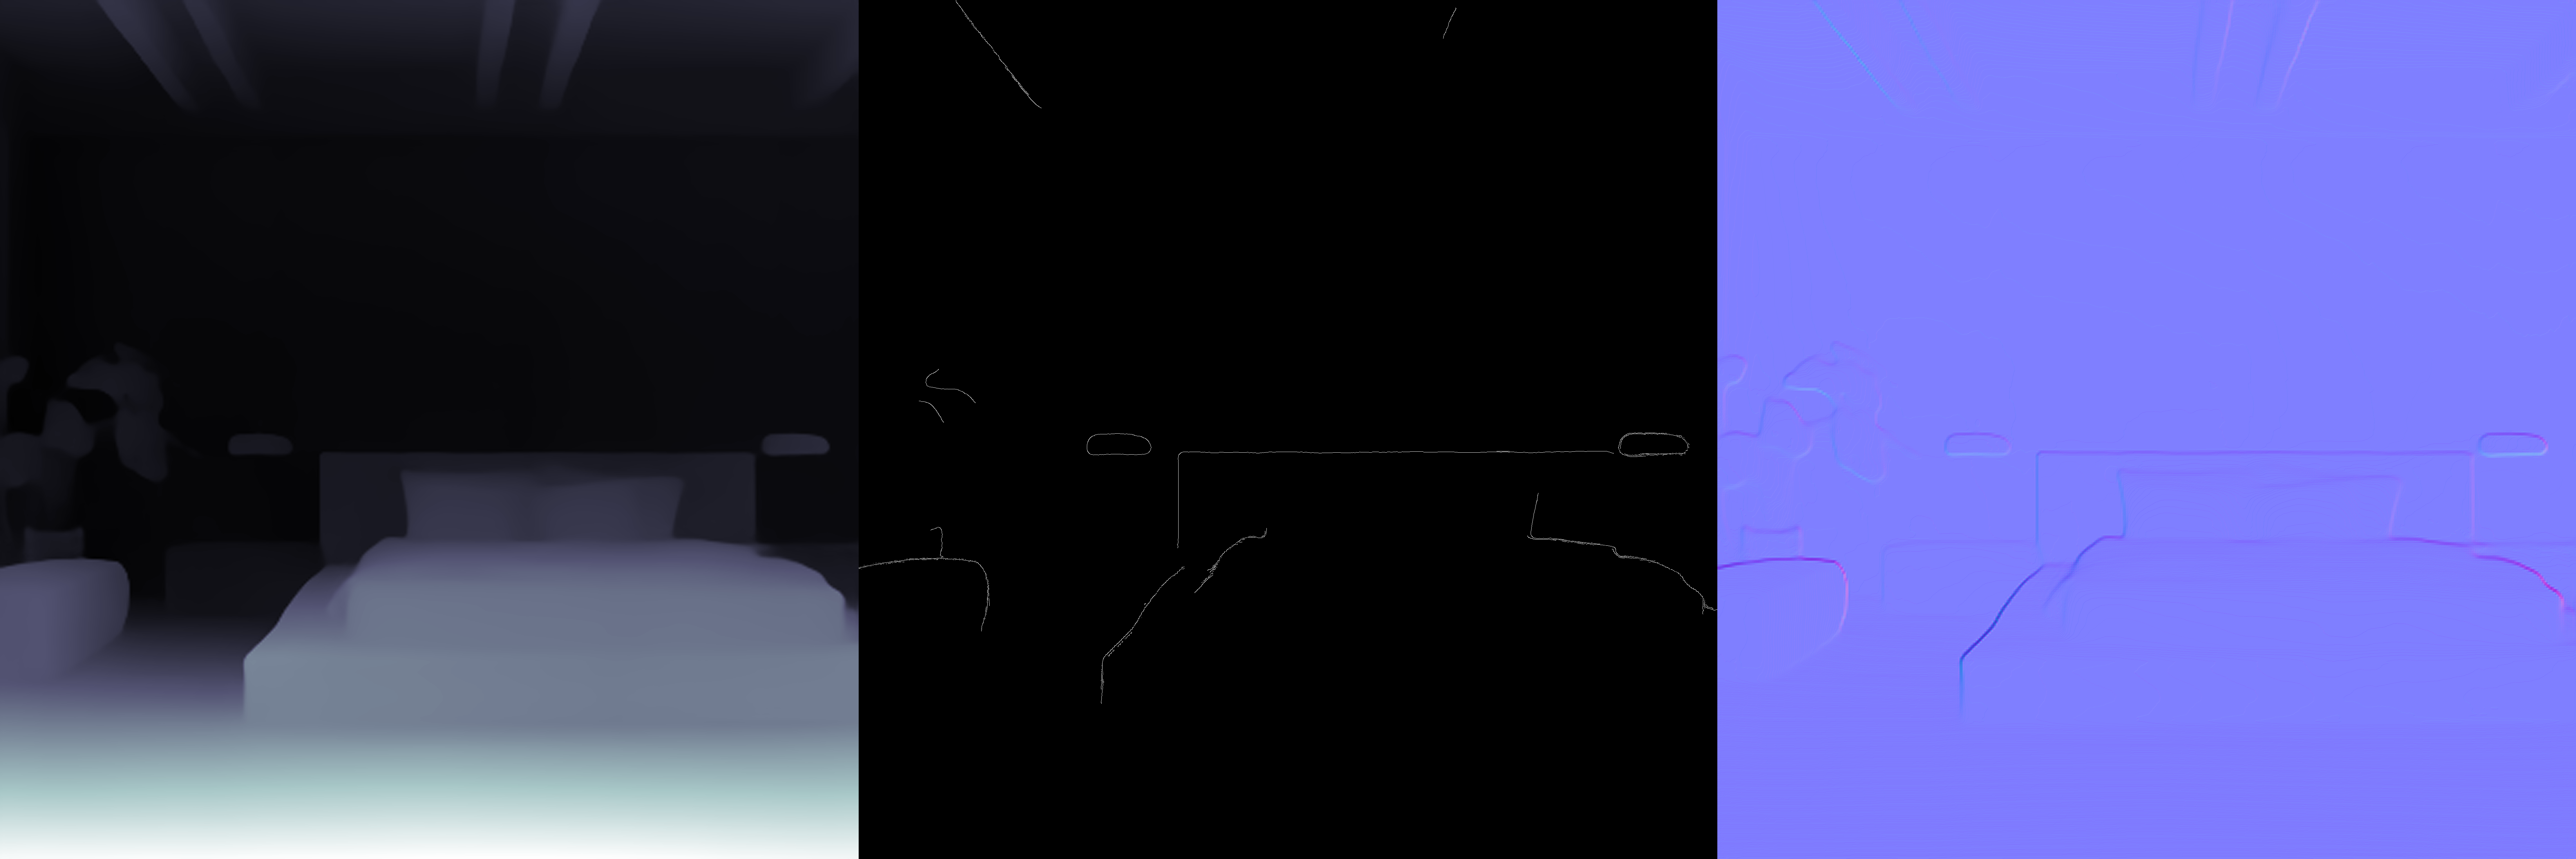

In [198]:
idx = 3
text_prompt = text_prompts[idx]
image_map = get_image_map(idx)
print(text_prompt)
conditioning_images = list(get_image_map(idx).values())
make_image_grid(conditioning_images, rows=1, cols=len(conditioning_images))

In [ ]:
all_outputs = []
titles = []
for i in range(len(parameters)) : 
    images = get_image_sequence(idx, parameters[i])
    output = pipelines[i](
        text_prompt, image=images, generator=generator
    ).images[0]
    all_outputs.append(output)
    titles.append(get_title(parameters[i]))
    
display_images_with_titles(all_outputs, titles)

 40%|█████████████████████████████████████▏                                                       | 20/50 [01:18<01:57,  3.92s/it]

In [ ]:
idx = 4
text_prompt = text_prompts[idx]
image_map = get_image_map(idx)
print(text_prompt)
conditioning_images = list(get_image_map(idx).values())
make_image_grid(conditioning_images, rows=1, cols=len(conditioning_images))

In [ ]:
all_outputs = []
titles = []
for i in range(len(parameters)) : 
    images = get_image_sequence(idx, parameters[i])
    output = pipelines[i](
        text_prompt, image=images, generator=generator
    ).images[0]
    all_outputs.append(output)
    titles.append(get_title(parameters[i]))
    
display_images_with_titles(all_outputs, titles)

Key Factors Influencing Latency
Number of Inference Steps: The more steps you use during generation, the longer it will take. Reducing steps can significantly decrease latency but may affect image quality 14.
Image Resolution: Higher resolution images take longer to generate. For example, generating a 512x512 image is faster than a 1024x1024 image 45.
Hardware Configuration: The type of GPU or CPU used can greatly affect performance. For instance, using an A100 GPU can yield faster generation times compared to consumer-grade GPUs 5.
Batch Size: Increasing batch size can improve throughput but may also increase individual generation times due to resource constraints 

In [66]:
!nvidia-smi

Mon Sep 30 15:08:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L40S                    On  | 00000000:4A:00.0 Off |                    0 |
| N/A   31C    P0              78W / 350W |   2350MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--